In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, glob, pprint, hashlib
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

DATA_DIR = ''
PROC_DIR = DATA_DIR + '/processed'

Mounted at /content/gdrive


In [ ]:
print("PROC_DIR exists?", os.path.exists(PROC_DIR))
print(sorted(glob.glob(PROC_DIR + "/*.parquet"))[:10])

principal = pd.read_parquet(os.path.join(PROC_DIR, 'principal_clean.parquet'))
train_pr  = pd.read_parquet(os.path.join(PROC_DIR, 'train_clean.parquet'))
valid_pr  = pd.read_parquet(os.path.join(PROC_DIR, 'valid_clean.parquet'))
test_pr   = pd.read_parquet(os.path.join(PROC_DIR, 'test_clean.parquet'))

### **Visualização dos dados**



In [ ]:
CURRENCY_FILTER = None
ROLLING_DAYS = 7
CONF_LEVEL_Z = 1.96

In [ ]:
df = principal.copy()
df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True, errors='coerce')

In [ ]:
if CURRENCY_FILTER is not None and 'pay_currency' in df.columns:
    df = df[df['pay_currency'] == CURRENCY_FILTER]

vals = df['amount_paid'].astype('float64', copy=False)

df['day'] = df['timestamp'].dt.floor('D')

In [ ]:
grp = df.groupby('day', sort=True)['amount_paid']
daily = grp.agg(['count', 'sum', 'mean', 'std'])

n = daily['count'].to_numpy()
se = np.divide(daily['std'].to_numpy(), np.sqrt(np.where(n > 0, n, np.nan)))
ci = CONF_LEVEL_Z * se

ci[(n <= 1) | ~np.isfinite(ci)] = 0.0

daily['ci95'] = ci
if ROLLING_DAYS:
    daily['mean_ma'] = daily['mean'].rolling(ROLLING_DAYS, min_periods=1).mean()

In [ ]:
def br_currency(x, pos):
    s = f"{x:,.2f}".replace(",", "X").replace(".", ",").replace("X", ".")
    return f"R$ {s}"

fmt_br = FuncFormatter(br_currency)

def setup_xdates(ax):
    loc = mdates.AutoDateLocator()
    ax.xaxis.set_major_locator(loc)
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(loc))
    ax.grid(True, alpha=0.25)

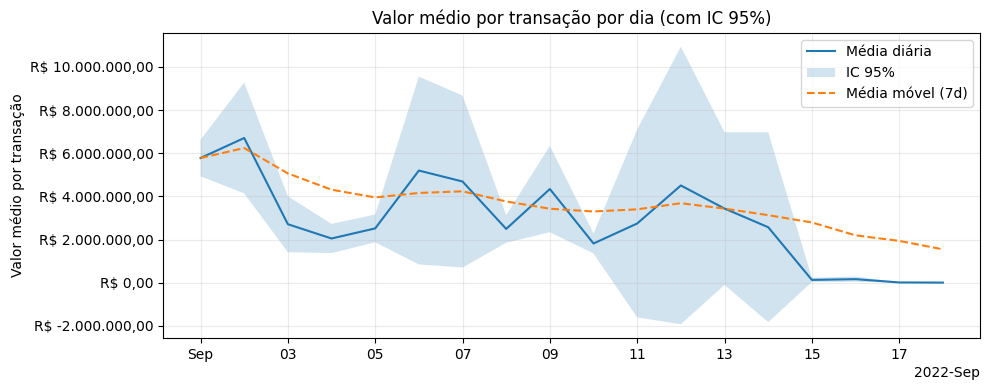

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(daily.index, daily['mean'], label='Média diária')
lower = daily['mean'] - daily['ci95']
upper = daily['mean'] + daily['ci95']
ax.fill_between(daily.index, lower, upper, alpha=0.2, label='IC 95%')

if ROLLING_DAYS:
    ax.plot(daily.index, daily['mean_ma'], linestyle='--', label=f'Média móvel ({ROLLING_DAYS}d)')

ax.set_title('Valor médio por transação por dia (com IC 95%)')
ax.set_ylabel('Valor médio por transação')
ax.yaxis.set_major_formatter(fmt_br)
setup_xdates(ax)
ax.legend()
plt.tight_layout()
plt.show()

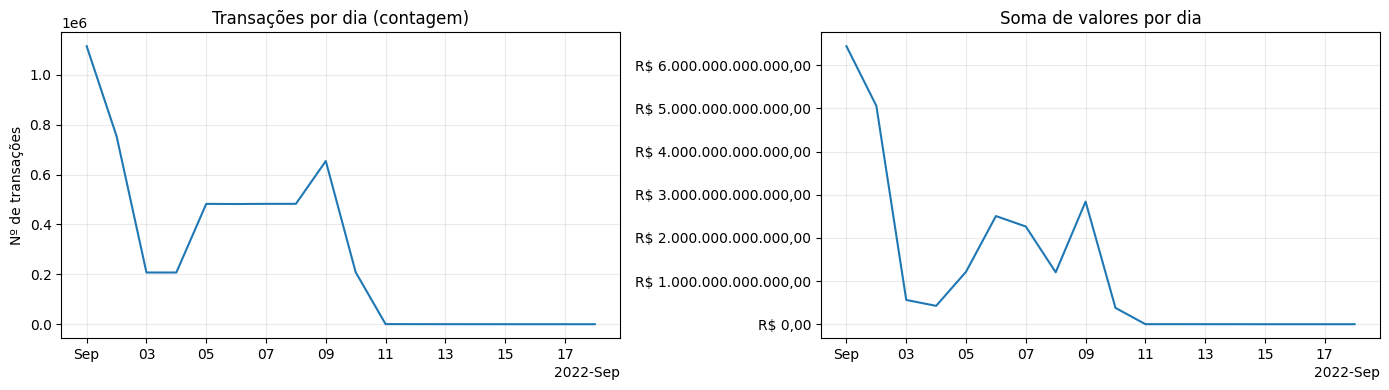

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4), sharex=True)

ax1.plot(daily.index, daily['count'])
ax1.set_title('Transações por dia (contagem)')
ax1.set_ylabel('Nº de transações')
setup_xdates(ax1)

ax2.plot(daily.index, daily['sum'])
ax2.set_title('Soma de valores por dia')
ax2.yaxis.set_major_formatter(fmt_br)
setup_xdates(ax2)

plt.tight_layout()
plt.show()

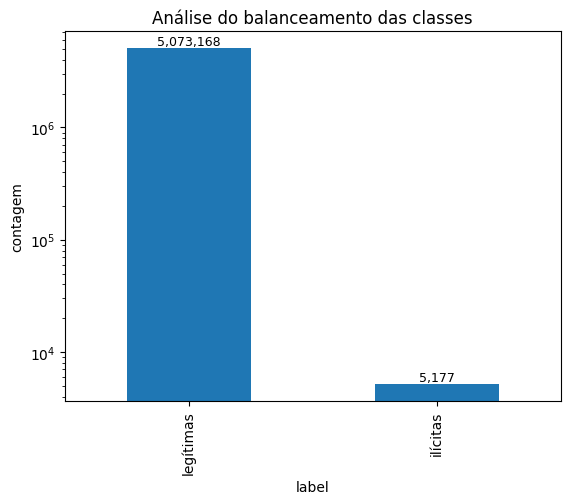

In [ ]:
#desbalanceamento
vc = principal['label'].value_counts().sort_index()  # 0,1
ax = vc.rename({0:'legítimas', 1:'ilícitas'}).plot(kind='bar')
ax.set_title('Análise do balanceamento das classes')
ax.set_ylabel('contagem')
ax.set_yscale('log')

for i, v in enumerate(vc.values):
    ax.text(i, v, f'{v:,}', ha='center', va='bottom', fontsize=9)

plt.show()

### **Feature engineering**

In [ ]:
def _hash_bucket(series: pd.Series, n_buckets: int = 10000, salt: str = "v1") -> pd.Series:
    def _h(x):
        if x is None or (isinstance(x, float) and np.isnan(x)):
            x = "UNK"
        s = (salt + str(x)).encode("utf-8")
        return int(hashlib.md5(s).hexdigest(), 16) % n_buckets
    return series.astype("string").map(_h).astype("int32")

def _keep_mask_by_hash(series: pd.Series, keep_rate: float, salt: str) -> pd.Series:
    buckets = 10000
    h = _hash_bucket(series, n_buckets=buckets, salt=salt)
    thr = int(keep_rate * buckets)
    return h < thr

In [ ]:
assert 'label' in principal.columns, "Esperado campo 'label' (0=lícito, 1=ilícito)"
n_total = len(principal)
n_pos = int((principal['label'] == 1).sum())
n_neg = n_total - n_pos
ratio = n_neg / max(1, n_pos)
print(f"Total={n_total:,} | ilícitas={n_pos:,} | lícitas={n_neg:,} | razão lícito/ilícito ≈ {ratio:.1f}:1")

Total=5,078,345 | ilícitas=5,177 | lícitas=5,073,168 | razão lícito/ilícito ≈ 979.9:1


In [ ]:
KEEP_RATE = 0.01
MODE = "by_account"

In [ ]:
df = principal.copy()
df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True, errors='coerce')

if MODE == "by_account":
    #seleciona um subconjunto de contas (origem/destino) e mantém TODAS as transações delas
    m_src = _keep_mask_by_hash(df['src_account'], KEEP_RATE, salt="src_v1")
    m_dst = _keep_mask_by_hash(df['dst_account'], KEEP_RATE, salt="dst_v1")
    base_mask = m_src | m_dst
else:
    #seleção por transação
    if 'tx_id' in df.columns:
        base_mask = _keep_mask_by_hash(df['tx_id'], KEEP_RATE, salt="tx_v1")
    else:
        base_mask = _keep_mask_by_hash(df['src_account'].astype(str) + '->' + df['dst_account'].astype(str) + '|' + df['timestamp'].astype(str),
                                       KEEP_RATE, salt="tx_v1")

In [ ]:
mask_pos = (df['label'] == 1)
mask = base_mask | mask_pos

sampled = df.loc[mask].copy()

nS = len(sampled)
nS_pos = int((sampled['label'] == 1).sum())
nS_neg = nS - nS_pos
ratioS = nS_neg / max(1, nS_pos)
print(f"[SAMPLE] Total={nS:,} | ilícitas={nS_pos:,} | lícitas={nS_neg:,} | razão ≈ {ratioS:.1f}:1")

[SAMPLE] Total=101,358 | ilícitas=5,177 | lícitas=96,181 | razão ≈ 18.6:1


In [ ]:
raw_path = os.path.join(DATA_DIR, f"principal_sample_{MODE}_{int(KEEP_RATE*10000)}bps.parquet")
sampleed_columns = sampled.columns.tolist()
sampled.to_parquet(raw_path, index=False)
print("Salvo:", raw_path)

In [ ]:
def add_time_safe_tx_features(
    pdf,
    col_ts='timestamp',
    col_src='src_account',
    col_dst='dst_account',
    col_amt='amount_paid',
    K=50,
    alpha=0.3,
    n_buckets=4096
):
    pdf = pdf.sort_values(col_ts).copy()
    pdf['_dow']  = pdf[col_ts].dt.dayofweek.astype('int8')
    pdf['_hour'] = pdf[col_ts].dt.hour.astype('int8')
    pdf['_amt_log'] = np.log1p(pdf[col_amt]).astype('float32')

    if 'src_bank' in pdf.columns and 'dst_bank' in pdf.columns:
        pdf['_same_bank'] = (pdf['src_bank'] == pdf['dst_bank']).astype('int8')
    else:
        pdf['_same_bank'] = 0

    if 'pay_currency' in pdf.columns and 'recv_currency' in pdf.columns:
        pdf['currency_pair'] = (pdf['pay_currency'].fillna('UNK') + '->' + pdf['recv_currency'].fillna('UNK')).astype('string')
        pdf['cp_bucket'] = _hash_bucket(pdf['currency_pair'], n_buckets=n_buckets, salt="cp_v1")
    elif 'currency_pair' in pdf.columns:
        pdf['currency_pair'] = pdf['currency_pair'].astype('string')
        pdf['cp_bucket'] = _hash_bucket(pdf['currency_pair'], n_buckets=n_buckets, salt="cp_v1")
    else:
        pdf['currency_pair'] = 'UNK'
        pdf['cp_bucket'] = 0

    gsrc = pdf.groupby(col_src, sort=False)
    pdf['_src_tx_count_prev'] = gsrc.cumcount().astype('int32')
    prev_src_amt = gsrc[col_amt].shift()

    pdf['_src_amt_sum_prev']  = prev_src_amt.groupby(pdf[col_src]).expanding().sum().reset_index(level=0, drop=True).fillna(0).astype('float32')
    pdf['_src_amt_mean_prev'] = prev_src_amt.groupby(pdf[col_src]).expanding().mean().reset_index(level=0, drop=True).fillna(0).astype('float32')
    pdf['_src_amt_std_prev']  = prev_src_amt.groupby(pdf[col_src]).expanding().std().reset_index(level=0, drop=True).fillna(0).astype('float32')
    pdf['_src_secs_since_last'] = (pdf[col_ts] - gsrc[col_ts].shift()).dt.total_seconds().fillna(-1).astype('float32')

    pdf['_src_roll_mean_K'] = prev_src_amt.groupby(pdf[col_src]).rolling(K, min_periods=1).mean().reset_index(level=0, drop=True).astype('float32')
    pdf['_src_roll_std_K']  = prev_src_amt.groupby(pdf[col_src]).rolling(K, min_periods=2).std().reset_index(level=0, drop=True).fillna(0).astype('float32')
    pdf['_src_roll_sum_K']  = prev_src_amt.groupby(pdf[col_src]).rolling(K, min_periods=1).sum().reset_index(level=0, drop=True).astype('float32')
    pdf['_src_ewm_mean']    = prev_src_amt.groupby(pdf[col_src]).apply(lambda s: s.ewm(alpha=alpha, adjust=False).mean()).reset_index(level=0, drop=True).astype('float32')

    gdst = pdf.groupby(col_dst, sort=False)
    pdf['_dst_rx_count_prev'] = gdst.cumcount().astype('int32')
    prev_dst_amt = gdst[col_amt].shift()

    pdf['_dst_amt_sum_prev']  = prev_dst_amt.groupby(pdf[col_dst]).expanding().sum().reset_index(level=0, drop=True).fillna(0).astype('float32')
    pdf['_dst_amt_mean_prev'] = prev_dst_amt.groupby(pdf[col_dst]).expanding().mean().reset_index(level=0, drop=True).fillna(0).astype('float32')
    pdf['_dst_amt_std_prev']  = prev_dst_amt.groupby(pdf[col_dst]).expanding().std().reset_index(level=0, drop=True).fillna(0).astype('float32')
    pdf['_dst_secs_since_last'] = (pdf[col_ts] - gdst[col_ts].shift()).dt.total_seconds().fillna(-1).astype('float32')

    pdf['_dst_roll_mean_K'] = prev_dst_amt.groupby(pdf[col_dst]).rolling(K, min_periods=1).mean().reset_index(level=0, drop=True).astype('float32')
    pdf['_dst_roll_std_K']  = prev_dst_amt.groupby(pdf[col_dst]).rolling(K, min_periods=2).std().reset_index(level=0, drop=True).fillna(0).astype('float32')
    pdf['_dst_roll_sum_K']  = prev_dst_amt.groupby(pdf[col_dst]).rolling(K, min_periods=1).sum().reset_index(level=0, drop=True).astype('float32')
    pdf['_dst_ewm_mean']    = prev_dst_amt.groupby(pdf[col_dst]).apply(lambda s: s.ewm(alpha=alpha, adjust=False).mean()).reset_index(level=0, drop=True).astype('float32')

    eps = 1e-6
    pdf['_src_amt_z'] = ((pdf[col_amt] - pdf['_src_amt_mean_prev']) / (pdf['_src_amt_std_prev'] + eps)).astype('float32')
    pdf['_dst_amt_z'] = ((pdf[col_amt] - pdf['_dst_amt_mean_prev']) / (pdf['_dst_amt_std_prev'] + eps)).astype('float32')
    return pdf

In [ ]:
sampled_feats = add_time_safe_tx_features(sampled)
feat_path = os.path.join(PROC_DIR, f"principal_sample_feats_{MODE}_{int(KEEP_RATE*10000)}bps.parquet")
sampled_feats.to_parquet(feat_path, index=False)
print("Salvo:", feat_path)